#FINAL EXPORT (BEST MODEL)

In [3]:
from pathlib import Path
import subprocess

ROOT = Path(subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip())


In [ ]:

# # FINAL EXPORT (BEST MODEL) — NN baseline without rolling7 (Kaggle ~0.19488)

# %%
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
from tensorflow import keras

# 1) Load data


train_path = ROOT / "data" / "processed" / "df_train_data_cleaned.csv"
val_path   = ROOT / "data" / "processed" / "df_validation_data_cleaned.csv"
test_path  = ROOT / "data" / "processed" / "df_test_data_cleaned.csv"



df_train = pd.read_csv(train_path)
df_val   = pd.read_csv(val_path)
df_test  = pd.read_csv(test_path)

#add month to all datasets
df_train['month'] = pd.to_datetime(df_train['Datum']).dt.month
df_val['month'] = pd.to_datetime(df_val['Datum']).dt.month
df_test['month'] = pd.to_datetime(df_test['Datum']).dt.month

#is_last_day_of_year
df_train['is_last_day_of_year'] = pd.to_datetime(df_train['Datum']).dt.is_year_end.astype(int)
df_val['is_last_day_of_year'] = pd.to_datetime(df_val['Datum']).dt.is_year_end.astype(int)
df_test['is_last_day_of_year'] = pd.to_datetime(df_test['Datum']).dt.is_year_end.astype(int)

for df in (df_train, df_val, df_test):
    df["Datum"] = pd.to_datetime(df["Datum"], errors="coerce")

target = "Umsatz_umsatz"

# 2) Split X/y
X_train = df_train.drop(columns=[target, "Datum"])
y_train = df_train[target].astype(float)

X_val = df_val.drop(columns=[target, "Datum"])
y_val = df_val[target].astype(float)

# test has no target
X_test = df_test.drop(columns=["Datum"])

# 3) Drop rolling7 (best model)
drop_cols = ["umsatz_rolling7","temperature_2m_mean","sunshine_duration","is_saturday","is_sunday"]
X_train = X_train.drop(columns=drop_cols, errors="ignore")
X_val   = X_val.drop(columns=drop_cols, errors="ignore")
X_test  = X_test.drop(columns=drop_cols, errors="ignore")

# 4) Ensure categorical as string
cat_cols = ["Warengruppe_umsatz", "day_of_week", "KielerWoche_kiwo", "month", "is_last_day_of_year"]
for df in (X_train, X_val, X_test):
    df["Warengruppe_umsatz"] = df["Warengruppe_umsatz"].astype(int).astype(str)

# 5) Align columns (very important)
# make sure val/test have exactly same feature columns as train
X_val  = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# 6) Preprocess (scaling + one-hot)
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

X_train_p = preprocess.fit_transform(X_train)
X_val_p   = preprocess.transform(X_val)
X_test_p  = preprocess.transform(X_test)

print("Shapes:", X_train_p.shape, X_val_p.shape, X_test_p.shape)

# 7) Build + train NN (same architecture)
tf.random.set_seed(42)

model = keras.Sequential([
    keras.layers.Input(shape=(X_train_p.shape[1],)),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mape",                 # to match Kaggle metric
    metrics=["mae"]
)

early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_p, y_train,
    validation_data=(X_val_p, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early],
    verbose=1
)

# quick sanity check on val (MAPE)
pred_val = model.predict(X_val_p).ravel()
pred_val = np.clip(pred_val, 0, None)
val_mape = mean_absolute_percentage_error(y_val, pred_val) * 100
print(f"Validation MAPE %: {val_mape:.2f}")

# 8) Predict test + create submission
pred_test = model.predict(X_test_p).ravel()
pred_test = np.clip(pred_test, 0, None)

submission = df_test[["id"]].copy()
submission["umsatz"] = pred_test

out_path   = ROOT / "data" / "processed" / "submission_nn_best.csv"
submission.to_csv(out_path, index=False)

print("Saved:", out_path)
print("rows:", len(submission))
print("pred mean/min/max:",
      float(submission["umsatz"].mean()),
      float(submission["umsatz"].min()),
      float(submission["umsatz"].max()))
print(submission.head())


Shapes: (7487, 36) (1841, 36) (1830, 36)


2026-01-08 17:08:52.349274: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 68.2444 - mae: 158.5313 - val_loss: 41.1864 - val_mae: 100.3213
Epoch 2/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38.7427 - mae: 98.5405 - val_loss: 30.3867 - val_mae: 70.1364
Epoch 3/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.0915 - mae: 65.1952 - val_loss: 24.1393 - val_mae: 48.8822
Epoch 4/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.0615 - mae: 52.1482 - val_loss: 23.0009 - val_mae: 45.6744
Epoch 5/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.9362 - mae: 48.8517 - val_loss: 22.2382 - val_mae: 43.7157
Epoch 6/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.0786 - mae: 46.7250 - val_loss: 21.5244 - val_mae: 41.8841
Epoch 7/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.2729 - mae: 44.7889 - val_loss: 20.8426 - val_mae: 40.0593
Epoch 8/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20.4604 - mae: 43.0136 - val_loss: 20.2537 - val_mae: 38.4067
Epoch 9/200
23

In [7]:
print("y_train min/max:", y_train.min(), y_train.max())
print("pred_val min/max:", pred_val.min(), pred_val.max())

y_train min/max: 12.9373828412174 1879.46183076734
pred_val min/max: 31.088442 677.4227


In [9]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# predictions already computed: pred_val
rmse = np.sqrt(mean_squared_error(y_val, pred_val))
r2   = r2_score(y_val, pred_val)
mae  = mean_absolute_error(y_val, pred_val)

print(f"Validation MAPE %: {val_mape:.2f}")
print(f"Validation RMSE : {rmse:.2f}")
print(f"Validation R2   : {r2:.4f}")
print(f"Validation MAE  : {mae:.2f}")

Validation MAPE %: 17.45
Validation RMSE : 49.53
Validation R2   : 0.8550
Validation MAE  : 30.06


#Plot 1: Loss curves (Train vs Val)

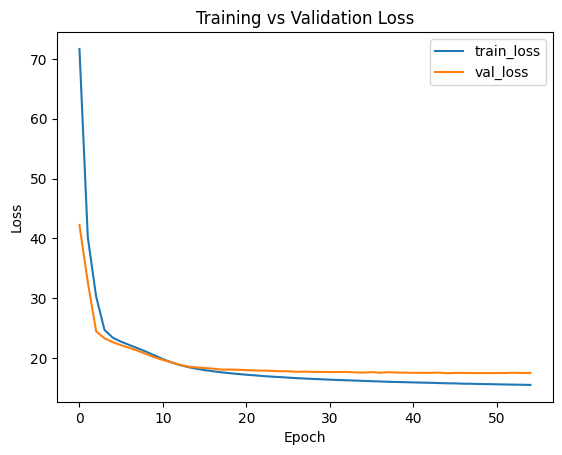

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


#Plot 2: Actual vs Pred (Validation)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


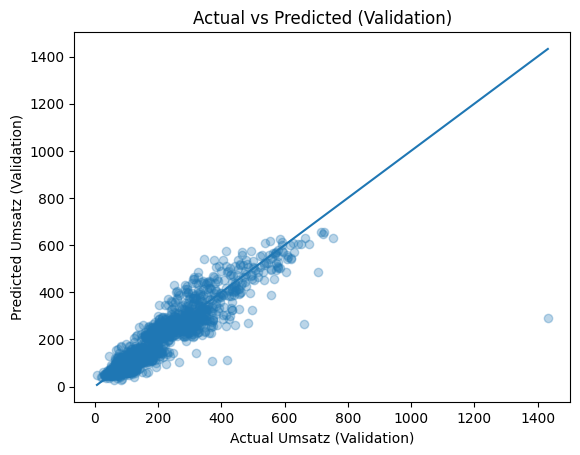

In [6]:
import numpy as np
import matplotlib.pyplot as plt

pred_val = model.predict(X_val_p).ravel()
pred_val = np.clip(pred_val, 0, None)

plt.figure()
plt.scatter(y_val, pred_val, alpha=0.3)
plt.xlabel("Actual Umsatz (Validation)")
plt.ylabel("Predicted Umsatz (Validation)")
plt.title("Actual vs Predicted (Validation)")

mn = min(y_val.min(), pred_val.min())
mx = max(y_val.max(), pred_val.max())
plt.plot([mn, mx], [mn, mx])
plt.show()


#MAPE Overall + each Product Group (Warengruppe)

In [7]:
import pandas as pd
import numpy as np

# Predictions on validation
pred_val = model.predict(X_val_p).ravel()
pred_val = np.clip(pred_val, 0, None)

# overall MAPE
overall_mape = np.mean(np.abs((y_val.values - pred_val) / y_val.values)) * 100
print(f"Overall Validation MAPE: {overall_mape:.2f}%")

# per-group MAPE
val_results = df_val[["Warengruppe_umsatz"]].copy()
val_results["y_true"] = y_val.values
val_results["y_pred"] = pred_val

mape_by_group = (
    val_results
    .groupby("Warengruppe_umsatz")
    .apply(lambda g: np.mean(np.abs((g["y_true"] - g["y_pred"]) / g["y_true"])) * 100)
    .reset_index(name="MAPE_%")
    .sort_values("MAPE_%", ascending=False)
)

display(mape_by_group)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Overall Validation MAPE: 19.04%


/tmp/ipykernel_12627/3864057258.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.mean(np.abs((g["y_true"] - g["y_pred"]) / g["y_true"])) * 100)


,Warengruppe_umsatz,MAPE_%
5,6.0,47.592200
3,4.0,23.597462
0,1.0,19.271647
2,3.0,17.760478
4,5.0,15.785916
1,2.0,14.308977


#Worst Fail & Best Improvement:

In [1]:
import numpy as np

val_results = df_val[["Datum","Warengruppe_umsatz"]].copy()
val_results["y_true"] = y_val.values
val_results["y_pred"] = np.clip(model.predict(X_val_p).ravel(), 0, None)

# APE  
val_results["APE_%"] = np.abs((val_results["y_true"] - val_results["y_pred"]) / val_results["y_true"]) * 100

# Worst Fail
worst = val_results.sort_values("APE_%", ascending=False).head(10)
print("Worst Fail examples:")
display(worst)

# Baseline : mean per product group (on train)
group_mean_train = df_train.groupby("Warengruppe_umsatz")["Umsatz_umsatz"].mean()

val_results["baseline_pred"] = val_results["Warengruppe_umsatz"].map(group_mean_train)
val_results["baseline_APE_%"] = np.abs((val_results["y_true"] - val_results["baseline_pred"]) / val_results["y_true"]) * 100

# Best improvement = baseline_APE - model_APE
val_results["improvement_%"] = val_results["baseline_APE_%"] - val_results["APE_%"]
best_improve = val_results.sort_values("improvement_%", ascending=False).head(10)

print("Best Improvement examples:")
display(best_improve)


NameError: name 'df_val' is not defined